# **Importation**


In [1]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import glob
from PIL import Image

from io import BytesIO

import imgaug.augmenters as iaa


# **Fonction predict**

In [17]:
def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = load_img(url, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = img_array.reshape((-1, 150, 150, 3))
    res = model.predict(img_array)[0][0]

    if res < 0.5:
        diagnostic = "Négatif"
        prob = 1 - res
    else:
        diagnostic = "Positif"
        prob = res

    plt.imshow(array_to_img(img_array[0]))
    plt.axis("off")
    plt.title(f"{diagnostic} ({prob:.2%})")


    return  plt.show()



# **Extraction data**



In [2]:
def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = load_img(url, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = img_array.reshape((-1, 150, 150, 3))
    res = model.predict(img_array)[0][0]

    if res < 0.5:
        diagnostic = "Négatif"
        prob = 1 - res
    else:
        diagnostic = "Positif"
        prob = res

    plt.imshow(array_to_img(img_array[0]))
    plt.axis("off")
    plt.title(f"{diagnostic} ({prob:.2%})")


    return  plt.show()

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = "/content/drive/MyDrive/Data_prepros.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/drive/MyDrive/Data_prepros.zip"
extract_path = "/content/data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")


Extraction terminée !


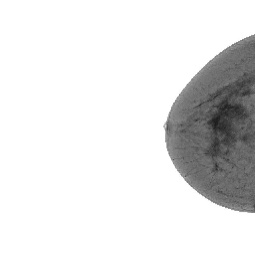

In [5]:
load_img('/content/data/Data_prepros/test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg')

In [6]:
folder_path = "/content/data/Data_prepros"

train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

In [7]:
train_dataset = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

validation_dataset = image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

Found 4744 files belonging to 2 classes.
Found 1350 files belonging to 2 classes.
Found 672 files belonging to 2 classes.


# 1 Premier model, simple sans kernel regularized

In [8]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,527,745 (24.90 MB)

 Trainable params: 6,527,745 (24.90 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6292 - loss: 7.0446 - recall: 0.1033

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.6294 - loss: 7.0127 - recall: 0.1028 - val_accuracy: 0.6637 - val_loss: 0.6785 - val_recall: 0.0000e+00
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6616 - loss: 0.6751 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_loss: 0.6647 - val_recall: 0.0000e+00
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6633 - loss: 0.6622 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_loss: 0.6551 - val_recall: 0.0000e+00
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6683 - loss: 0.6520 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_loss: 0.6489 - val_recall: 0.0000e+00
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6654 - loss: 0.6471 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_loss: 0.6448 - val_recall: 0.0000e+00
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6651 - loss: 0.6435 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_lo

In [10]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6367 - loss: 0.6566 - recall: 0.0000e+00
Test accuracy: 0.6190476417541504
Test recall: 0.0


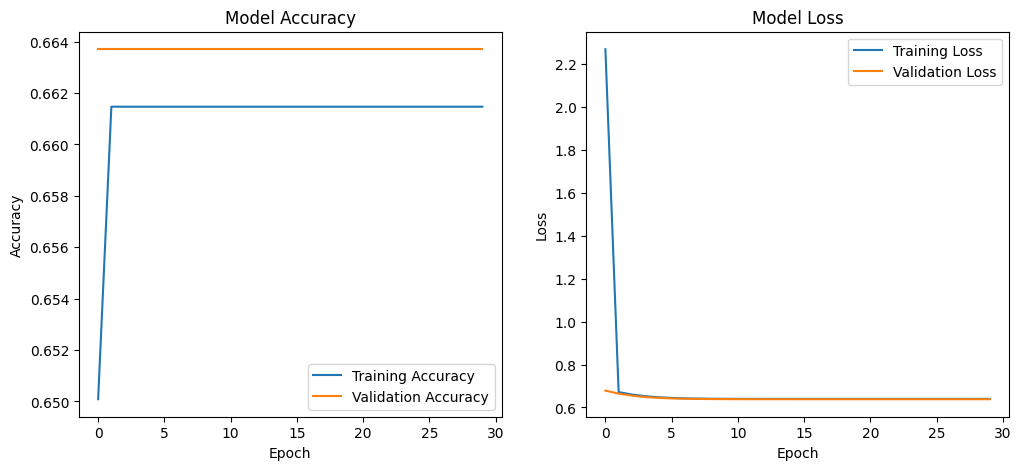

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 2 Deuxieme model, plus de couche sans regularizer

In [12]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu", ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))


model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 220, 220, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 108, 108, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 106, 106, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 51, 51, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 49, 49, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 47, 47, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 47, 47, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 565504)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      72,384,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,799,825 (277.71 MB)

 Trainable params: 72,799,825 (277.71 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6316 - loss: 1.2680 - recall: 0.1220

149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.6318 - loss: 1.2649 - recall: 0.1214 - val_accuracy: 0.6637 - val_loss: 0.6509 - val_recall: 0.0000e+00
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6646 - loss: 0.6427 - recall: 0.0333 - val_accuracy: 0.6578 - val_loss: 0.6343 - val_recall: 0.2665
Epoch 3/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6765 - loss: 0.6251 - recall: 0.1557

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6764 - loss: 0.6251 - recall: 0.1553 - val_accuracy: 0.6652 - val_loss: 0.6283 - val_recall: 0.2269
Epoch 4/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6729 - loss: 0.6123 - recall: 0.1772

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6729 - loss: 0.6123 - recall: 0.1767 - val_accuracy: 0.6741 - val_loss: 0.6249 - val_recall: 0.1740
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6780 - loss: 0.6024 - recall: 0.1856 - val_accuracy: 0.6696 - val_loss: 0.6311 - val_recall: 0.2797
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6907 - loss: 0.5879 - recall: 0.2822 - val_accuracy: 0.6437 - val_loss: 0.6331 - val_recall: 0.3260
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7104 - loss: 0.5679 - recall: 0.3258 - val_accuracy: 0.6726 - val_loss: 0.6434 - val_recall: 0.2731
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7125 - loss: 0.5545 - recall: 0.3854 - val_accuracy: 0.6607 - val_loss: 0.6440 - val_recall: 0.2753
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7262 - loss: 0.5445 - recall: 0.3922 - val_accuracy: 0.6467 - val_loss: 0.6468 - val_recall: 0.2026
Epoch 10/

In [14]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5861 - loss: 1.2375 - recall: 0.3142
Test accuracy: 0.5877976417541504
Test recall: 0.3125


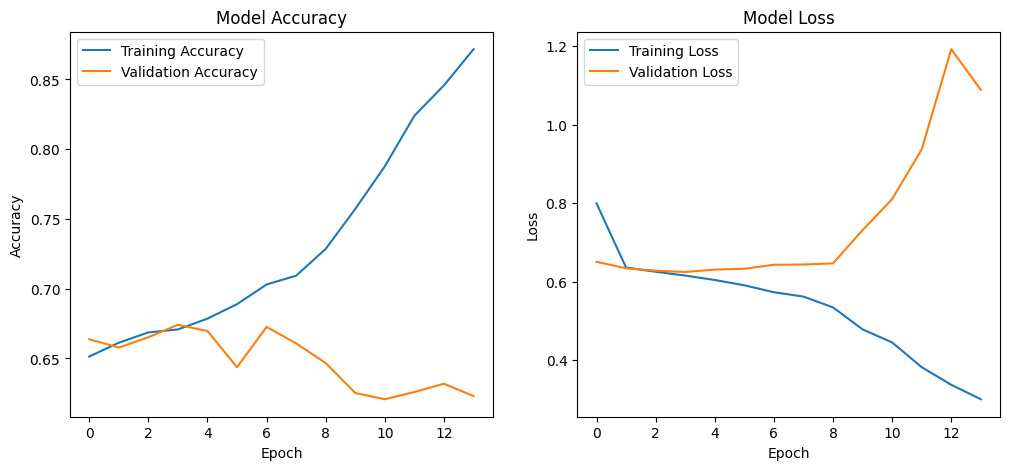

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **3 Troisième modèle avec ElasticNet, lasso, ridge**

In [16]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu", ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))


model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 220, 220, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 108, 108, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 106, 106, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 51, 51, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 49, 49, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 47, 47, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 47, 47, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 565504)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      72,384,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,799,825 (277.71 MB)

 Trainable params: 72,799,825 (277.71 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6283 - loss: 2.9827 - recall: 0.0930

149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.6284 - loss: 2.9707 - recall: 0.0927 - val_accuracy: 0.6637 - val_loss: 0.6478 - val_recall: 0.0000e+00
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6675 - loss: 0.6463 - recall: 0.0046 - val_accuracy: 0.6630 - val_loss: 0.6342 - val_recall: 0.1718
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6727 - loss: 0.6291 - recall: 0.1209 - val_accuracy: 0.6585 - val_loss: 0.6325 - val_recall: 0.2137
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6735 - loss: 0.6174 - recall: 0.1822 - val_accuracy: 0.6504 - val_loss: 0.6354 - val_recall: 0.2555
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6892 - loss: 0.6012 - recall: 0.2803 - val_accuracy: 0.6519 - val_loss: 0.6391 - val_recall: 0.2907
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6902 - loss: 0.5848 - recall: 0.3089 - val_accuracy: 0.6548 - val_loss: 0.6391 - val_recall: 0.3568
Epoc

In [18]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6116 - loss: 1.1049 - recall: 0.3629
Test accuracy: 0.6071428656578064
Test recall: 0.3359375


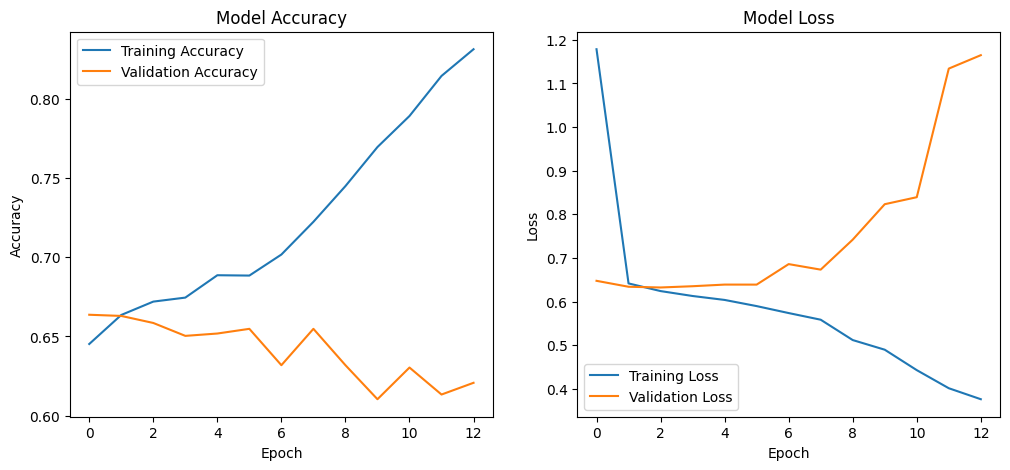

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Exporter EfficientNetB5 et ajout de couche de neurone**

In [12]:
# Charger EfficientNetB5
base_model = EfficientNetB5(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle le modèle pré-entraîné au début

In [15]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff1 = Model(inputs=base_model.input, outputs=output_layer)

model_eff1.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,735,160 (113.43 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [16]:
model_eff1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model_eff1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6062 - loss: 10.6822 - recall: 0.2484

149/149 ━━━━━━━━━━━━━━━━━━━━ 100s 336ms/step - accuracy: 0.6064 - loss: 10.6626 - recall: 0.2481 - val_accuracy: 0.6593 - val_loss: 3.2391 - val_recall: 0.0617
Epoch 2/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6645 - loss: 2.4420 - recall: 0.1145

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6645 - loss: 2.4314 - recall: 0.1145 - val_accuracy: 0.6837 - val_loss: 1.2125 - val_recall: 0.1344
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6606 - loss: 1.0819 - recall: 0.0983 - val_accuracy: 0.6667 - val_loss: 0.8399 - val_recall: 0.0176
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6685 - loss: 0.7960 - recall: 0.0499 - val_accuracy: 0.6800 - val_loss: 0.7284 - val_recall: 0.0903
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6680 - loss: 0.7193 - recall: 0.0913 - val_accuracy: 0.6652 - val_loss: 0.6957 - val_recall: 0.0374
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6666 - loss: 0.6816 - recall: 0.0350 - val_accuracy: 0.6793 - val_loss: 0.6820 - val_recall: 0.0903
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6752 - loss: 0.6732 - recall: 0.0925 - val_accuracy: 0.6696 - val_loss: 0.6733 - val_recall: 0.1850
Epoch 8/3

In [23]:
test_loss, test_acc, test_recall = model_eff1.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6397 - loss: 0.6701 - recall: 0.2544
Test accuracy: 0.6309523582458496
Test recall: 0.24609375


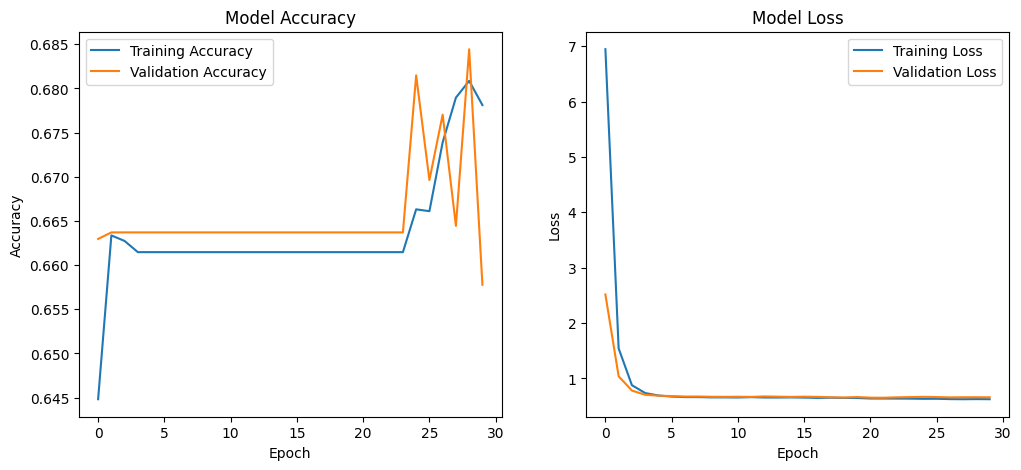

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff2 = Model(inputs=base_model.input, outputs=output_layer)

model_eff2.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,087,480 (110.96 MB)

 Trainable params: 569,857 (2.17 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [24]:
model_eff2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model_eff2.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5928 - loss: 6.5948 - recall: 0.2913

149/149 ━━━━━━━━━━━━━━━━━━━━ 102s 339ms/step - accuracy: 0.5930 - loss: 6.5861 - recall: 0.2909 - val_accuracy: 0.6585 - val_loss: 3.0845 - val_recall: 0.1035
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6538 - loss: 2.4801 - recall: 0.1443 - val_accuracy: 0.6644 - val_loss: 1.3920 - val_recall: 0.1035
Epoch 3/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6720 - loss: 1.2254 - recall: 0.1576

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6721 - loss: 1.2232 - recall: 0.1576 - val_accuracy: 0.6800 - val_loss: 0.9460 - val_recall: 0.2203
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6736 - loss: 0.8887 - recall: 0.1286 - val_accuracy: 0.6711 - val_loss: 0.7945 - val_recall: 0.1894
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6761 - loss: 0.7629 - recall: 0.1546 - val_accuracy: 0.6770 - val_loss: 0.7184 - val_recall: 0.1630
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6789 - loss: 0.7046 - recall: 0.1486 - val_accuracy: 0.6778 - val_loss: 0.6926 - val_recall: 0.1057
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6811 - loss: 0.6751 - recall: 0.1128 - val_accuracy: 0.6600 - val_loss: 0.6803 - val_recall: 0.2203
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6813 - loss: 0.6694 - recall: 0.1409 - val_accuracy: 0.6733 - val_loss: 0.6732 - val_recall: 0.1872
Epoch 9/3

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6671 - loss: 0.6631 - recall: 0.1480 - val_accuracy: 0.6570 - val_loss: 0.6793 - val_recall: 0.2731
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6719 - loss: 0.6602 - recall: 0.1749 - val_accuracy: 0.6807 - val_loss: 0.6574 - val_recall: 0.1542
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6758 - loss: 0.6494 - recall: 0.1643 - val_accuracy: 0.6637 - val_loss: 0.6659 - val_recall: 0.0441
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6691 - loss: 0.6581 - recall: 0.1038

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6692 - loss: 0.6580 - recall: 0.1041 - val_accuracy: 0.6578 - val_loss: 0.6587 - val_recall: 0.2974
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6721 - loss: 0.6519 - recall: 0.1933 - val_accuracy: 0.6756 - val_loss: 0.6642 - val_recall: 0.2026
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6840 - loss: 0.6456 - recall: 0.2358 - val_accuracy: 0.6733 - val_loss: 0.6684 - val_recall: 0.2093
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6787 - loss: 0.6506 - recall: 0.2031 - val_accuracy: 0.6674 - val_loss: 0.6618 - val_recall: 0.2952
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6820 - loss: 0.6477 - recall: 0.2599 - val_accuracy: 0.6533 - val_loss: 0.6591 - val_recall: 0.2313
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6758 - loss: 0.6436 - recall: 0.2263 - val_accuracy: 0.6689 - val_loss: 0.6628 - val_recall: 0.2115
Epoc

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6923 - loss: 0.6441 - recall: 0.2613 - val_accuracy: 0.6667 - val_loss: 0.6811 - val_recall: 0.3612
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6967 - loss: 0.6417 - recall: 0.3158 - val_accuracy: 0.6593 - val_loss: 0.6663 - val_recall: 0.3150
Epoch 23/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6897 - loss: 0.6409 - recall: 0.2662 - val_accuracy: 0.6763 - val_loss: 0.6563 - val_recall: 0.2313
Epoch 24/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7044 - loss: 0.6350 - recall: 0.2801 - val_accuracy: 0.6778 - val_loss: 0.6553 - val_recall: 0.2313
Epoch 25/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6854 - loss: 0.6455 - recall: 0.2450 - val_accuracy: 0.6756 - val_loss: 0.6633 - val_recall: 0.2797
Epoch 26/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7041 - loss: 0.6305 - recall: 0.3224 - val_accuracy: 0.6689 - val_loss: 0.6558 - val_recall: 0.3326
Epoc

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6965 - loss: 0.6324 - recall: 0.3161 - val_accuracy: 0.6756 - val_loss: 0.6533 - val_recall: 0.3634
Epoch 28/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7027 - loss: 0.6285 - recall: 0.3412 - val_accuracy: 0.6696 - val_loss: 0.6558 - val_recall: 0.2797
Epoch 29/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7013 - loss: 0.6306 - recall: 0.3524 - val_accuracy: 0.6733 - val_loss: 0.6539 - val_recall: 0.2952
Epoch 30/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7049 - loss: 0.6217 - recall: 0.3316 - val_accuracy: 0.6444 - val_loss: 0.6775 - val_recall: 0.3238


In [25]:
test_loss, test_acc, test_recall = model_eff2.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6072 - loss: 0.7103 - recall: 0.3818
Test accuracy: 0.6101190447807312
Test recall: 0.36328125


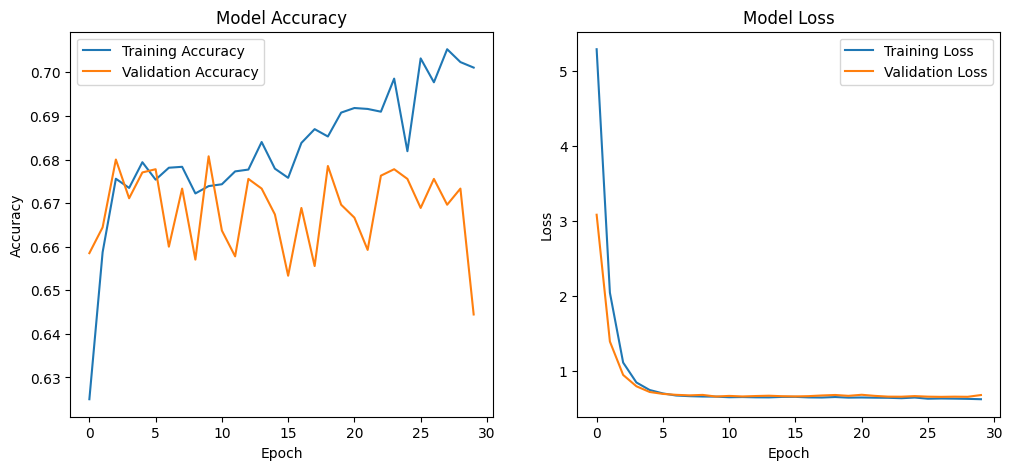

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()